In [19]:
!pip install rich
from rich import print
print("Current branch name: ")
!git branch --show-current
try:
    import tensorflow_datasets, tensorflow, matplotlib, numpy, PIL, sklearn
except:
    !pip install tensorflow_datasets tensorflow matplotlib numpy pillow scikit-learn
    import tensorflow_datasets, tensorflow, matplotlib, numpy, PIL, sklearn

try:
    import keras_tuner as kt
except:
    !pip install keras-tuner
    import keras_tuner as kt

try:
    import cv2
except:
    !pip install opencv-python
    import cv2
import os

Current branch name:

3D


# Dataset Selection

In [20]:
# DO NOT TOUCH BELOW ==================================
FULL_DATASET = 0
FULL_BINARY_DATASET = 1
MY_DATASET = 2
MY_BIN_DATASET = 3

# DO NOT TOUCH - END ===================================

# select dataset
SELECTED_DATASET = MY_DATASET # CHANGE HERE



# DO NOT TOUCH BELOW ==================================
FULL_DATASET_PATH = r'D:\CGC work\Alziehmer Disease\PhdNotebook\OASIS dataset\OASIS dataset\Data'
FULL_BINARY_DATASET_PATH = r'D:\CGC work\Alziehmer Disease\PhdNotebook\OASIS dataset Binary\OASIS dataset\Data'
MY_DATASET_PATH = r'/Users/soumensardar/Downloads/OASIS/'
MY_DATASET_BINARY_PATH = r'/Users/soumensardar/Downloads/OASIS-binary/'

# while adding more datasets, make sure to add tflog directory
datasetdir, dataset_name =[  (FULL_DATASET_PATH, 'tflogs_3d'),
                             (FULL_BINARY_DATASET_PATH, 'tflogs_binary_3d'),
                             (MY_DATASET_PATH, 'tflogs_my_3d'),
                             (MY_DATASET_BINARY_PATH, 'tflogs_mybin_3d'),
                    ][SELECTED_DATASET]
# DO NOT TOUCH - END ===================================
datasetdir, dataset_name
assert os.path.exists(datasetdir), f"Dataset path is incorrect {datasetdir}"

# Test Image selection

In [21]:
TEST_IMG_PATH, TEST_IMG_LABEL = [
(r'D:\CGC work\Alziehmer Disease\PhdNotebook\OASIS dataset\OASIS dataset\Data\Mild Dementia/OAS1_0028_MR1_mpr-1_127.jpg', 'Mild_Dementia'),
(r'D:\CGC work\Alziehmer Disease\PhdNotebook\OASIS dataset Binary\OASIS dataset\Data\1. Mild Dementia/OAS1_0028_MR1_mpr-1_127.jpg', '1. Mild_Dementia'),
(r'/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0028_MR1_mpr-1_127.jpg', 'Mild Dementia'),
(r'/Users/soumensardar/Downloads/OASIS-binary/Mild Dementia/OAS1_0028_MR1_mpr-1_127.jpg', '1. Mild Dementia'),
][SELECTED_DATASET]
import os
assert os.path.exists(TEST_IMG_PATH), f"Test image path is incorrect {TEST_IMG_PATH}"
TEST_IMG_PATH, TEST_IMG_LABEL

('/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0028_MR1_mpr-1_127.jpg',
 'Mild Dementia')

In [22]:
import os, json
def get_experiment_details(dataset, model, ts):
    exp_asset_dir = f"results/{dataset}/{model}/{ts}"
    assert os.path.exists(exp_asset_dir), f"Experiment does not exist '{exp_asset_dir}'"
    checkpoint_model_dir = None
    with open(exp_asset_dir + "/currentepoch.txt") as fp:
        last_epoch = int(fp.read().strip())
        checkpoint_model_dir = exp_asset_dir + "/models/epoch=%02d.h5"%last_epoch
        assert os.path.exists(checkpoint_model_dir), f"Unable to find the last checkpoint file {checkpoint_model_dir}"
    best_model_dir = exp_asset_dir + "/models/best-model.h5"
    if not os.path.exists(best_model_dir):
        best_model_dir = None

    best_model_info = None
    if os.path.exists(exp_asset_dir + "/bestvalue.json"):
        with open(exp_asset_dir + "/bestvalue.json") as fp:
            best_model_info = json.load(fp)
        
    return dict(last_epoch=last_epoch, 
                best_checkpoint=best_model_dir, 
                last_checkpoint=checkpoint_model_dir,
                best_model_info=best_model_info,
                project_dir=exp_asset_dir)

# <font color='red'>Hyperparameters

In [23]:
random_seed=37
resume_training_timestamp = None # CHANGE HERE
max_epoch = 50 # CHANGE HERE
batch_size = 64 # CHANGE HERE
image_size = 128
color_mode = 'rgb'
n_ch = dict(rgb=3, grayscale=1)[color_mode]
monitor = "f1_score"
initial_threshold = 0.5
mode="max"
freq="epoch"
initial_epoch=0
learning_rate = 0.001
enable_class_weight = False
ablation_study_size = batch_size * 30 # CHANGE HERE

task_type = "binary" # "categorical"
# Link: https://www.tensorflow.org/api_docs/python/tf/keras/losses#functions
if task_type == "binary":
    activation = "sigmoid"
    loss_function = "binary_crossentropy"
else:
    activation = "softmax"
    loss_function = "categorical_crossentropy"
lr_schedular = False
resume_checkpoint_path = None
# Link: https://keras.io/api/applications/
model_name="MobileNet" # CHANGE HERE !!!!!!!
# add a comment about what changes you have done just now before running the training
what_changed = f"Training with {model_name=} {task_type=} {lr_schedular=} {activation=} {loss_function=}"

In [24]:
import tensorflow as tf
# EACH LINK CONTAINS AVAILABLE OPTIONS
# Link: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers#classes
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # CHANGE HERE
# Link: https://www.tensorflow.org/api_docs/python/tf/keras/metrics#classes
metrics = [tf.keras.metrics.Accuracy(), 
           tf.keras.metrics.Recall(), 
           tf.keras.metrics.Precision(),
           tf.keras.metrics.F1Score(average="macro"),
           tf.keras.metrics.SensitivityAtSpecificity(0.6),
           tf.keras.metrics.SpecificityAtSensitivity(0.6),
          ]

2024-12-19 23:29:48.290617: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-12-19 23:29:48.290934: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-19 23:29:48.291431: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-19 23:29:48.292189: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-19 23:29:48.292787: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [25]:
# Learning rate schedular callback
def lr_schedule(epoch):
  """
  Returns a custom learning rate that decreases as epochs progress.
  """
  learning_rate = 0.02
  if epoch > 5:
    learning_rate = 0.01
  if epoch > 10:
    learning_rate = 0.0001
  if epoch > 15:
    learning_rate = 0.00001

  tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
  return learning_rate

In [26]:
if resume_training_timestamp:
    print(f"Trying to resume from checkpoint... {resume_training_timestamp}")
    d = get_experiment_details(dataset_name, model_name, resume_training_timestamp)
    initial_epoch = d['last_epoch']
    resume_checkpoint_path = d['last_checkpoint']
    assert os.path.exists(resume_checkpoint_path), f"Unable to resume training from '{d['project_dir']}'."
    best_model_info = d['best_model_info']
    if best_model_info:
        print("Updating the metric monitoring parameters before resuming the checkpoint")
        monitor = best_model_info['monitor']
        initial_threshold = best_model_info['value']
        mode=best_model_info['mode']
        freq=best_model_info['frequency']
    print(f"Resuming checkpoint form epoch={initial_epoch}.")
# =====================================================


def save_hparams():
    hyprams = dict(
            timestamp = timestamp,
            what_changed=what_changed,
            random_state=random_seed,
            max_epoch=max_epoch,
            batch_size=batch_size,
            image_size=image_size,
            num_channels=n_ch,
            metrics=str(metrics),
            loss_function=loss_function,
            monitoring=dict(monitor = monitor, initial_threshold = initial_threshold, mode=mode),
            resume_training_timestamp=resume_training_timestamp,
            initial_epoch=initial_epoch,
            model_name=model_name,
            optimizer=optimizer.name,
            learning_rate=learning_rate,
            lr_schedular=lr_schedular,
        )
    import json 
    log("Saving hyperparameters.")
    print(hyprams)
    # Convert and write JSON object to file
    with open(f"{artifact_root}/hyperparams.json", "w") as outfile: 
        json.dump(hyprams, outfile, indent=4)
    file_writer = tf.summary.create_file_writer(tf_log_dir + "/hparams")
    with file_writer.as_default():
        tf.summary.text("hyperparams.json", f"{artifact_root}/hyperparams.json", step=0)
        for k, v in hyprams.items():
            if isinstance(v, int):
                tf.summary.scalar(k, v, step=0)
            elif isinstance(v, float):
                tf.summary.scalar(k, v, step=0)
            else:
                tf.summary.text(k, str(v), step=0)

# Prepare artifact directory

In [27]:
import pathlib
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
if resume_training_timestamp:
    print("Resume timestamp", resume_training_timestamp)
    timestamp = resume_training_timestamp
unique_dir = f"{model_name}/{timestamp}"
tf_log_dir = f"results/{dataset_name}/{unique_dir}"
tf_log_img_dir = f"results/{dataset_name}/images"
artifact_root  = f"results/{dataset_name}/{unique_dir}"
pathlib.Path(artifact_root).mkdir(parents=True, exist_ok=True)
pathlib.Path(tf_log_dir).mkdir(parents=True, exist_ok=True)

def log(*args, **kwargs):
    time = False
    if "time" in kwargs.keys():
        time = kwargs["time"]
        del kwargs["time"]
    if time:
        time = datetime.datetime.now().strftime("%H:%M:%S %d/%m/%Y")
        a = list(args)
        a.append(time)
        args = tuple(a)
    print(*args, **kwargs)
    with open(f"{artifact_root}/additional_logs.txt", "a") as fp:
        kwargs["file"] = fp
        kwargs["flush"] = True
        print(*args, **kwargs)
log(f"Experiment path: '{artifact_root}'")

Experiment path: 'results/tflogs_my_3d/MobileNet/20241219-232950'

Experiment path: 'results/tflogs_my_3d/MobileNet/20241219-232950'

# <font color='red'>Training Resume Timestamp
## Use this `timestamp` to update `resume_training_timestamp` variable

In [28]:
log(f"Resume timestamp: {timestamp}")

Resume timestamp: 20241219-232950

Resume timestamp: 20241219-232950

In [29]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
#   DataGenerator to read images and rescale images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import os
import random
tf.random.set_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

# Loading 3D datasets

In [87]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import json
import pathlib
import numpy as np
import cv2, hashlib

def md5(data):
    md5_hash = hashlib.md5()
    md5_hash.update(data.encode('utf-8'))
    return md5_hash.hexdigest()

class OASISDataset:

    def __init__(self, path, batch_size, preprocesing=None):
        self.path = pathlib.Path(path)
        self.classnames = [i for i in os.listdir(path) if i != ".DS_Store"]
        self.images = []
        self.batch_size = batch_size

    def _group_images_by_subject(self, image_dir):
        """Groups images by subject ID based on their filenames.
    
        Args:
            image_dir: Path to the directory containing the images.
    
        Returns:
            A dictionary where keys are subject IDs and values are lists of image filenames.
        """
    
        image_files = os.listdir(image_dir)
        subject_groups = {}
    
        for filename in image_files:
            # Extract subject ID from the filename (adjust the pattern as needed)
            # OAS1_0308_MR1_mpr-2_152.jpg
            subject_id = md5("_".join(filename.split('_')[0:-1]))
            if subject_id not in subject_groups:
                subject_groups[subject_id] = []
            subject_groups[subject_id].append(os.path.join(image_dir, filename))
        print("For", len(subject_groups.keys()), "patients,", len(image_files), f"images scanned from '{image_dir}'")
        return subject_groups
    
    def _list_images(self):
        for class_dir in self.classnames:
            grouped_files = self._group_images_by_subject((self.path / class_dir).resolve())
            self.images.extend(list(zip(grouped_files.values(), [class_dir]*len(grouped_files.values()))))

    def item_generator(self):
        for class_dir in self.classnames:
            grouped_files = self._group_images_by_subject((self.path / class_dir).resolve())
            for slices, label in zip(grouped_files.values(), [class_dir]*len(grouped_files.values())):
                yield from self.load_volume_from_files(slices, label)

    def load_volume_from_files(self, image_files: list, label: str):
        """Loads a 3D volume from a directory of JPEG images.
    
        Args:
            image_dir: Path to the directory containing the JPEG images.
    
        Returns:
            A 3D representing the 3D volume and encoded label.  -> tuple(tf.float32, tf.float32)
        """
    
        image_data = []
        print(image_files, list)
        for image_path in image_files:
            image = cv2.imread(image_path)
            image_data.append(image)
        volume = np.stack(image_data, axis=0)
        return tf.convert_to_tensor(volume, dtype=tf.float32), tf.convert_to_tensor(self.classnames.index(label), dtype=tf.float32)

    def get_dataset(self):
        """Creates a TensorFlow Dataset from a directory of images.
        
        Args:
        image_dir: Path to the directory containing the images.
        
        Returns:
        A TensorFlow Dataset.
        """
        dataset = tf.data.Dataset.from_generator(self.item_generator, 
                                                output_types=(tf.float32, tf.float32),
                                                output_shapes=(tf.TensorShape([160, image_size, image_size, 3]), tf.TensorShape([1]))
        )
        # dataset = dataset.map(self.load_volume_from_files, num_parallel_calls=tf.data.AUTOTUNE)
        # ... apply preprocessing and augmentation here ...
        # dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        
        return dataset
            
    
odd = OASISDataset(datasetdir, batch_size)
# odd.setup()
CLASS_NAMES = odd.classnames
print(CLASS_NAMES)
dataset = odd.get_dataset()
for images, labels in dataset:
    ...
# print(odd.images)

# # Example usage:
# image_dir = "path/to/your/images"
# volume = load_3d_volume(image_dir)

# raw_train_val_ds, raw_test_ds = tf.keras.utils.image_dataset_from_directory(
#   datasetdir,
#   validation_split=0.20,
#   subset='both',
#   label_mode = task_type,
#   color_mode=color_mode,
#   seed=random_seed,
#   image_size=(image_size, image_size),
#   batch_size=batch_size,
# )

# CLASS_NAMES = raw_train_val_ds.class_names
# if task_type == "binary":
#     num_classes = 1
# else:
#     num_classes = len(CLASS_NAMES)

# # Reducing dataset size for ablation study
# if ablation_study_size > 0:
#     batch_count = int(round(ablation_study_size / batch_size, 0))
#     raw_train_val_ds = raw_train_val_ds.take(batch_count)

print(CLASS_NAMES)
tf.data.Dataset?

['Mild Dementia', 'Very mild Dementia', 'Moderate Dementia', 'Non Demented']

For 82 patients, 5002 images scanned from '/Users/soumensardar/Downloads/OASIS/Mild Dementia'

[
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_139.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_105.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_111.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_110.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_104.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_138.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_112.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_106.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_107.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_113.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_117.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_103.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_102.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_116.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_100.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_114.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_128.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_129.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_115.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_101.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_159.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_158.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_160.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_148.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_149.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_147.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_153.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_152.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_146.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_150.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_144.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_145.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_151.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_155.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_141.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_140.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_154.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_142.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_156.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_157.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_143.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_118.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_124.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_130.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_131.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_125.jpg',
    '/Users/soumensardar/Downloads/OASIS/Mild Dementia/OAS1_0137_MR1_mpr-3_119.jpg',
   

2024-12-20 00:26:02.155609: W tensorflow/core/framework/op_kernel.cc:1816] INVALID_ARGUMENT: TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32), but the yielded element was [[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32), but the yielded element was [[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 ...


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]].
Traceback (most recent call last):

  File "/Users/soumensardar/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 204, in generator_py_func
    flattened_values = nest.flatten_up_to(output_types, values)

  File "/Users/soumensardar/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/data/util/nest.py", line 237, in flatten_up_to
    return nest_util.flatten_up_to(

  File "/Users/soumensardar/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/util/nest_util.py", line 1530, in flatten_up_to
    return _tf_data_flatten_up_to(shallow_tree, input_tree)

  File "/Users/soumensardar/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/util/nest_util.py", line 1559, in _tf_data_flatten_up_to
    _tf_data_assert_shallow_structure(shallow_tree, input_tree)

  File "/Users/soumensardar/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/util/nest_util.py", line 1403, in _tf_data_assert_shallow_structure
    raise TypeError(

TypeError: If shallow structure is a sequence, input must also be a sequence. Input has type: 'EagerTensor'.


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/Users/soumensardar/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    ret = func(*args)

  File "/Users/soumensardar/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/Users/soumensardar/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 206, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32), but the yielded element was [[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 ...


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]].


	 [[{{node PyFunc}}]] [Op:IteratorGetNext] name: 

].


2024-12-20 00:26:02.165410: W tensorflow/core/framework/op_kernel.cc:1816] INVALID_ARGUMENT: TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32), but the yielded element was 0.0.
Traceback (most recent call last):

  File "/Users/soumensardar/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 204, in generator_py_func
    flattened_values = nest.flatten_up_to(output_types, values)

  File "/Users/soumensardar/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/data/util/nest.py", line 237, in flatten_up_to
    return nest_util.flatten_up_to(

  File "/Users/soumensardar/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/util/nest_util.py", line 1530, in flatten_up_to
    return _tf_data_flatten_up_to(shallow_tree, input_tree)

  File "/Users/soumensardar/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/ut

## Dataset split

In [31]:
# Create a test dataset by further splitting the validation set
raw_val_batches = tf.data.experimental.cardinality(raw_train_val_ds)

raw_val_ds = raw_train_val_ds.take(raw_val_batches // 5) # 20% of validation as test
raw_train_ds = raw_train_val_ds.skip(raw_val_batches // 5)

"train=", len(raw_train_ds)*batch_size, "val=",len(raw_val_ds)*batch_size, "test=",len(raw_test_ds)*batch_size

NameError: name 'raw_train_val_ds' is not defined

## Dataset loading optimization and normalization

In [ ]:
import cv2, warnings
def bilateralFilter(image):
    """
    Try to apply bilateralFilter to an image.
    Raise warning in case of any error and finally return the image
    """
    try:
        npimg = image.numpy()
        npimg = cv2.bilateralFilter(npimg, 15, 75, 75) 
        image = tf.convert_to_tensor(npimg)
    except Exception as e:
        warnings.warn(f"Error while applying bilateral-filter. {e}")
        pass
    return image

def preprocess_image(image, label, for_human=False):
    # resize
    image = tf.image.resize(image, (image_size, image_size))
    # denoising
    image = bilateralFilter(image)
    # random flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if for_human is False:
        # standarization
        image = tf.image.per_image_standardization(image)
        # normalization
        # image = tf.keras.layers.Rescaling(1./255)(image)
    return image, label

num_threads = 10
train_ds = raw_train_ds.map(preprocess_image, num_parallel_calls=num_threads)
val_ds = raw_val_ds.map(preprocess_image, num_parallel_calls=num_threads)
test_ds = raw_test_ds.map(preprocess_image, num_parallel_calls=num_threads)

# Performance and caching
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Sample images

Sample labels tf.Tensor(
[[0.]
 [0.]
 [0.]], shape=(3, 1), dtype=float32)


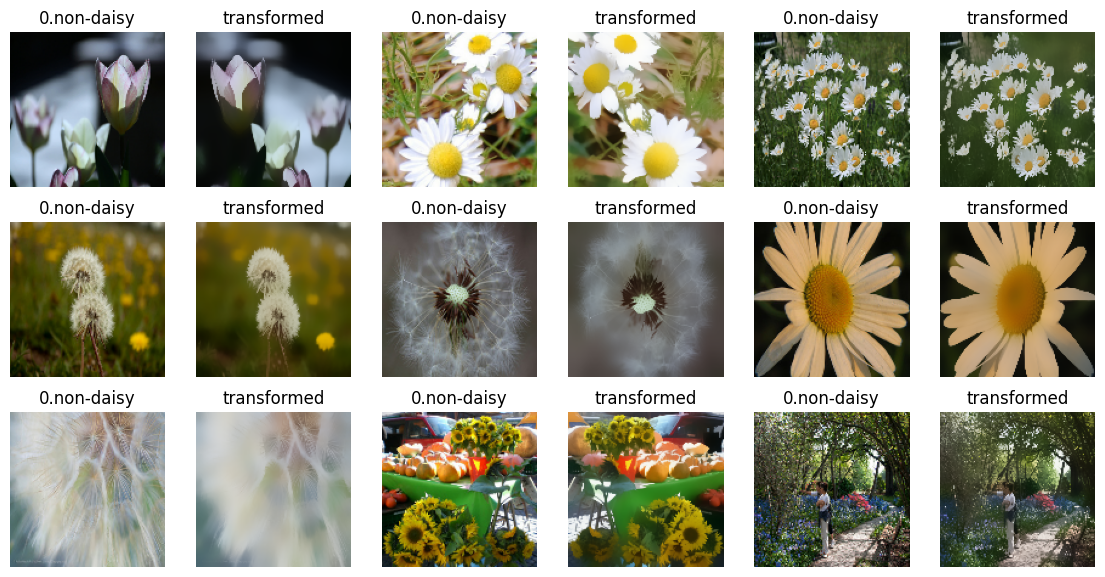

In [111]:
#print("Sample images")
plt.figure(figsize=(14,7))
for images, labels in raw_train_ds:
    print("Sample labels", labels[:3])
    for i,j in zip(range(1, 19, 2), range(2, 19, 2)):
        ax = plt.subplot(3, 6, i)
        plt.imshow(images[i].numpy().astype("uint8")) #, cmap='Greys_r')
        plt.title("%s"%CLASS_NAMES[np.argmax(labels[i])])
        plt.axis("off")
        ax = plt.subplot(3, 6, j)
        plt.imshow(preprocess_image(images[i], labels[i], for_human=True)[0].numpy().astype("uint8")) #, cmap='Greys_r')
        plt.title("transformed")
        plt.axis("off")
    break
plt.show()

## Visualiza the raw feature distributions

/var/folders/2x/kb1y9tvx01j9226b9fd1y13r0000gn/T/ipykernel_922/2831387045.py:15: RuntimeWarning: invalid value encountered in cast
  plt.imshow(image.astype("uint8"))


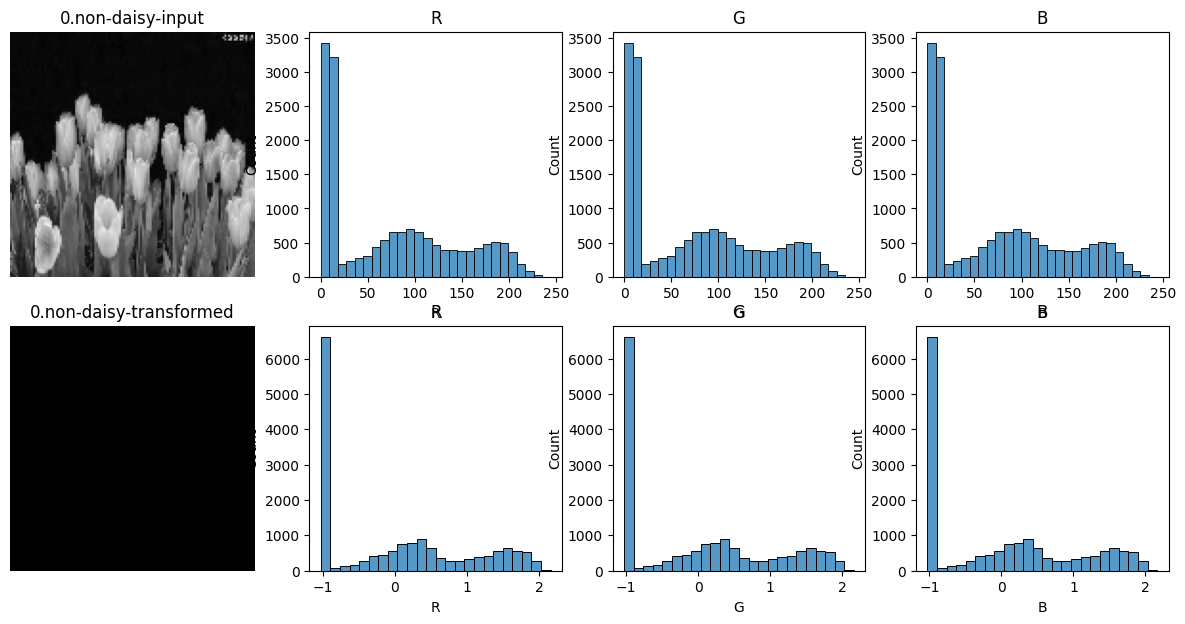

/var/folders/2x/kb1y9tvx01j9226b9fd1y13r0000gn/T/ipykernel_922/2831387045.py:15: RuntimeWarning: invalid value encountered in cast
  plt.imshow(image.astype("uint8"))


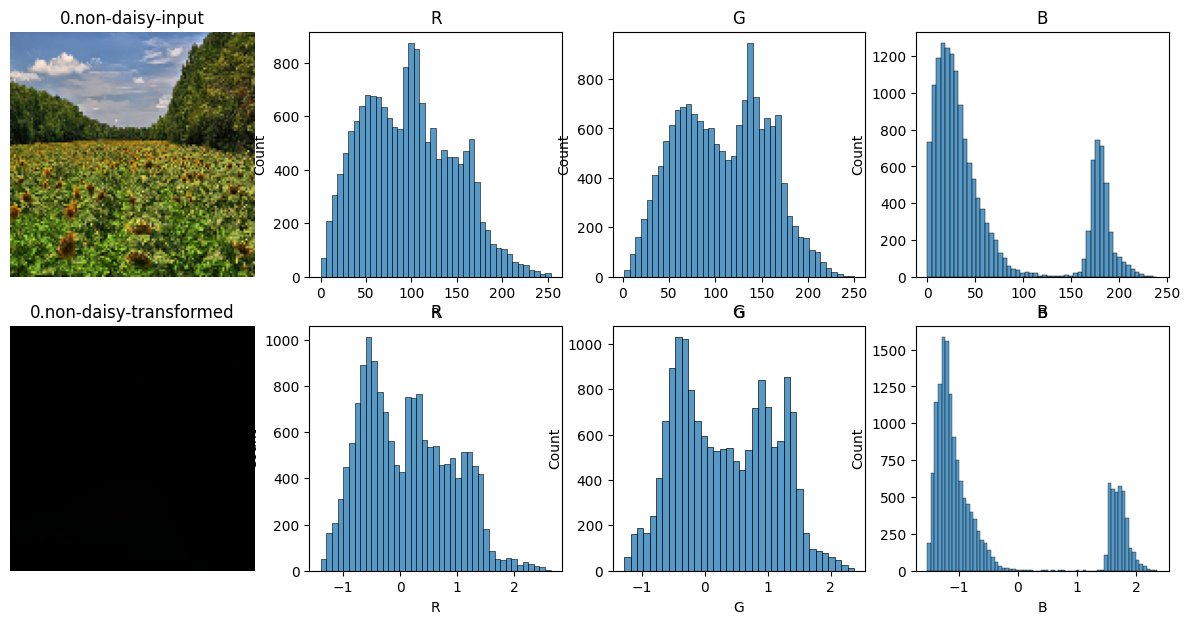

/var/folders/2x/kb1y9tvx01j9226b9fd1y13r0000gn/T/ipykernel_922/2831387045.py:15: RuntimeWarning: invalid value encountered in cast
  plt.imshow(image.astype("uint8"))


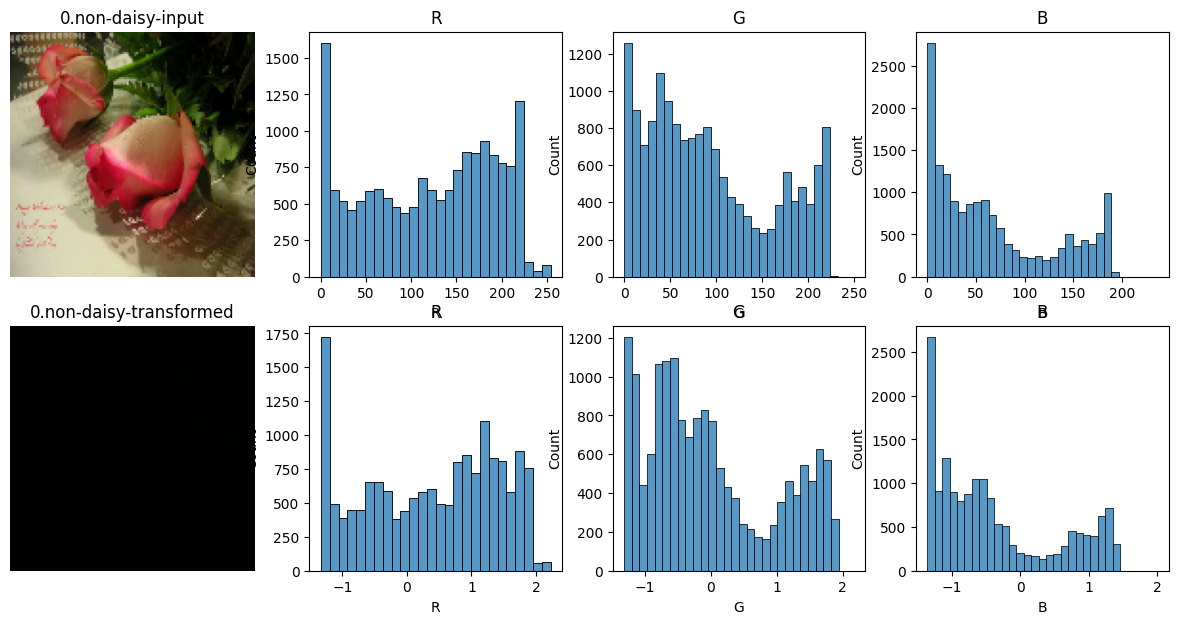

In [112]:
try:
    import seaborn as sns
    import pandas as pd
except:
    !pip install seaborn
    import seaborn as sns

def _get_dataframe(image: np.ndarray):
    return pd.DataFrame(image.reshape(-1, 3), columns=["R","G","B"])

def _render_image_histogram(image: np.ndarray, lbl, ax_idx, title):
    assert ax_idx in [1, 5], "We only support 1, 5 only"
    df = _get_dataframe(image)
    ax = plt.subplot(2, 4, ax_idx)
    plt.imshow(image.astype("uint8"))
    plt.title("%s-%s"%(lbl, title))
    plt.axis("off")
    for idx, ch in enumerate(df.columns):
        ax = plt.subplot(2, 4, ax_idx+idx+1)
        sns.histplot(ax=ax, data=df, x=ch)
        plt.title(ch)
        

for images, labels in raw_train_ds:
    for i in range(3):
        plt.figure(figsize=(15,7))
        _render_image_histogram(images[i].numpy(), CLASS_NAMES[np.argmax(labels[i])], 1, "input")
        _render_image_histogram(preprocess_image(images[i], labels[i])[0].numpy(), CLASS_NAMES[np.argmax(labels[i])], 5, "transformed")
        plt.show()
    break

# Class Weight

In [113]:
class_weights = None

from collections import Counter

class SmartCounter(dict):
    def __add__(self, new_dict):
        for key, val in new_dict.items():
            curr = self.get(key, 0)
            self[key] = curr + val
        return self

    def total(self):
        return sum([v for k, v in self.items()])
if enable_class_weight:        
    if SELECTED_DATASET == FULL_DATASET:
        class_weights = {0: 0.09429095057324974, 1: 1.0, 2: 0.0, 3: 0.029412625550617813}
        class_weights = {0: 0.5, 1: 0.5, 2: 0.5, 3: 0.5} # focus on 'Mild Dementia'
        class_weights[CLASS_NAMES.index('Mild Dementia')] = 1.0
    else:
        print("Calculating normalized class weights")
        ctr = SmartCounter()
        for img, lbl in raw_train_val_ds:
            v = Counter(list(map(lambda x: CLASS_NAMES[x], np.argmax(lbl, axis=1))))
            ctr = ctr + v
        t = ctr.total()
        weights = {k: t/v for k, v in ctr.items()}
        
        ws = np.array(list(weights.values()))
        ks = np.array(list(weights.keys()))
        # normalize the weights
        ws = (ws - np.min(ws)) / (np.max(ws) - np.min(ws))
        norm_weights = {}
        # Make sure the order of the keys is intact,
        # thus preparing a new dictionary
        for k, w in zip(ks, ws):
            norm_weights[k] = w
        class_weights = {CLASS_NAMES.index(c):norm_weights[c] for c in CLASS_NAMES}

"Class Weight=========", class_weights

('Class Weight=========', None)

In [114]:
import math, io
def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  print("Preparing matplotlib to numpy")
  return image

def image_grid(ds, count=25):
    """Return a square grid of images as a tensor."""
    # Create a figure to contain the plot.
    n = int(math.sqrt(count))
    figure = plt.figure(figsize=(n*2,n*2))
    for images, labels in ds:
        for i in range(count):
            ax = plt.subplot(n, n, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(CLASS_NAMES[np.argmax(labels[i])])
            plt.axis("off")
        break
    return plot_to_image(figure)

def validation_image_grid(count=25):
    """Return a square grid of images as a tensor"""
    # Create a figure to contain the plot.
    print("Preparing sample grid for validation images")
    return image_grid(raw_val_ds, count)

def train_image_grid(count=25):
    """Return a square grid of images as a tensor."""
    # Create a figure to contain the plot.
    print("Preparing sample grid for training images")
    return image_grid(raw_train_ds, count)

def test_image_grid(count=25):
    """Return a square grid of images as a tensor."""
    # Create a figure to contain the plot.
    print("Preparing sample grid for testing images")
    return image_grid(raw_test_ds, count)
    

tf_exclusive_image_logger = tf.summary.create_file_writer(tf_log_img_dir)
with tf_exclusive_image_logger.as_default():
    tf.summary.image("Training Image Sample", train_image_grid(9), step=0)
    tf.summary.image("Validation Image Sample", validation_image_grid(4), step=0)
    tf.summary.image("Testing Image Sample", test_image_grid(4), step=0)

Preparing sample grid for training images
Preparing matplotlib to numpy
Preparing sample grid for validation images
Preparing matplotlib to numpy
Preparing sample grid for testing images
Preparing matplotlib to numpy


# Logger and Callbacks

In [115]:
# CSV Logger
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.callbacks import LambdaCallback, Callback, LearningRateScheduler
import shutil, glob

# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", 
                               mode="min", 
                               patience=7, 
                               min_delta=0.001,
                               verbose=1,
                               start_from_epoch=9,
                               restore_best_weights=True)

csv_logger = CSVLogger(artifact_root + '/metrics.csv')
# Tensorboard Logger
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tf_log_dir,
    histogram_freq=0,
    write_graph=False,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None    
)

model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    artifact_root + "/models/epoch={epoch:02d}.h5",
    monitor=monitor,
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode=mode,
    save_freq=freq,
    initial_value_threshold=initial_threshold,
)

model_best_ckpt = tf.keras.callbacks.ModelCheckpoint(
    artifact_root + "/models/best-model.h5",
    monitor=monitor,
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode=mode,
    save_freq=freq,
    initial_value_threshold=initial_threshold,
)

class BestModelEpochTrackerCallback(Callback):
    """
    This callback monitor best values and updates in a json file project_dir/bestvalue.json
    """
    def __init__(self, monitor, mode, initial_value_threshold=None, verbose=0):
        assert mode in ("min", "max")
        initial_thresh = initial_value_threshold
        self.monitor = monitor
        self.mode = mode
        self.best_value = initial_thresh
        if mode == "min":
            self.is_better = np.less
            if self.best_value is None:
                self.best_value = np.Inf
        elif mode == "max":
            self.is_better = np.greater
            if self.best_value is None:
                self.best_value = -np.Inf 
        self.verbose = verbose
        
    def on_epoch_end(self, epoch, metrics=None):
        curr_val = metrics.get(self.monitor, None)
        assert curr_val is not None, f"Unable to find the metric to monitor: {self.monitor}"
        if self.is_better(curr_val, self.best_value):
            update_path = artifact_root + "/bestvalue.json"
            if self.verbose:
                print(f"Epoch {epoch+1}: {self.monitor} improved form {self.best_value:.5f} to {curr_val:.5f} and saving updates to {update_path}")
            self.best_value = curr_val
            with open(update_path, "w") as fp:
                json.dump(dict(epoch=epoch+1, 
                               monitor=self.monitor, 
                               value=curr_val, 
                               mode=self.mode, 
                               frequency="epoch"
                              ), fp, indent=4)
        else:
            if self.verbose:
                self.print(f"Epoch {epoch+1}: {self.monitor} did not improved form {self.best_value}")
            
                

bestval_monitor_callback = BestModelEpochTrackerCallback(
    monitor=monitor,
    mode=mode,
    initial_value_threshold=initial_threshold,
)



class CleanupCallback(Callback):
    def on_epoch_begin(self, epoch, metrics=None):
        # clean last checkpoint assets
        last_epoch = epoch - 1
        # update current
        with open(artifact_root + "/currentepoch.txt", "w") as fp:
            fp.write(f"{epoch}")
        # look for last epoch checkpoint and delete
        pattern = artifact_root + "/models/epoch=%02d.h5" % (last_epoch)
        if os.path.exists(pattern):
            os.remove(pattern)
        
        
cleanup_callback = CleanupCallback()

lr_callback = LearningRateScheduler(lr_schedule)
if lr_schedular:
    callbacks = [lr_callback]
else:
    callbacks = []

callbacks.extend([csv_logger, tensorboard_callback, model_ckpt, model_best_ckpt, bestval_monitor_callback, cleanup_callback])


# Model build

In [116]:
# Define the model architecture (ResNet50)
# import tensorflow.keras as K
log("Building model...")
import keras as K
    
input_t= K.Input(shape=(image_size,image_size,n_ch))
res_model= getattr(K.applications, model_name)(include_top=False, weights="imagenet", input_tensor=input_t)
model_lenet = K.models.Sequential()
model_lenet.add(res_model)
model_lenet.add(K.layers.Flatten())
model_lenet.add(K.layers.Dense(num_classes, activation=activation))


# Compile the model
log("Compile model")
model_lenet.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

Building model...


Compile model


# Hyparparameter Optimization

In [117]:
# train_ds_shuffled = train_ds.shuffle(buffer_size=1024)
# train_ds = train_ds_shuffled.take(1000).batch(16)

# tuner = kt.Hyperband(model_lenet,
#                      objective='val_accuracy',
#                      max_epochs=10,
#                      factor=3,
#                      directory='my_dir',
#                      project_name='intro_to_kt')
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# tuner.search(train_ds_subset, epochs=50, validation_split=0.2, callbacks=[stop_early])

# # Get the optimal hyperparameters
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
# is {best_hps.get('learning_rate')}.""")

# exit()

# Training

In [ ]:
# reload checkpoint
if resume_checkpoint_path and os.path.exists(resume_checkpoint_path):
    log("Resuming training...", resume_checkpoint_path)
    model_lenet.load_weights(resume_checkpoint_path)
else:
    log("Fresh training...")
    initial_epoch = 0
# daving hyper-params
save_hparams()


# Train the model
log("Experiment: Started", time=True)
log(f"Starting training model={model_name}")
history = model_lenet.fit(train_ds, epochs=max_epoch, 
                          initial_epoch=initial_epoch, 
                          batch_size=batch_size, 
                          callbacks = callbacks,
                          class_weight=class_weights,
                          validation_data=val_ds)
log(f"Training done={model_name}")

In [ ]:
# Evaluate the model on the test set
log("Experiment: Evaluating", time=True)
log(f"Evaluating model={model_name}...")
test_result = model_lenet.evaluate(test_ds)

In [ ]:
class LossMetric(tf.keras.metrics.Metric):
    def __init__(self, name='loss', **kwargs):
        super().__init__(name='loss', **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        pass

    def result(self):
        return 0

In [ ]:
metrics.append(LossMetric())

log(f"{model_name}", {f"test_{k.name}":v for v,k in zip(test_result, metrics)})

# TF-logging test values
file_writer = tf.summary.create_file_writer(tf_log_dir + "/test")
with file_writer.as_default():
    for v, k in zip(test_result, metrics):
        tf.summary.scalar(f"test_{k.name}", v, step=0)

In [ ]:
from PIL import Image
def preprocess_image(image_path, target_size=(image_size, image_size)):
    # Open the image file
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a NumPy array
    img_array = np.array(img)
    # Expand dimensions to match the shape expected by the model (if necessary)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


# Example usage:
actual_class = TEST_IMG_LABEL
image_path = TEST_IMG_PATH
image_array = preprocess_image(image_path)
log("Shape of preprocessed image array:", image_array.shape)

# Predict probabilities
log("Experiment: Testing", time=True)
prediction_probabilities = model_lenet.predict(image_array)

# Get the index of the highest probability
predicted_class_index = np.argmax(prediction_probabilities)

# Define your class labels
class_labels = CLASS_NAMES

# Map the index to the corresponding class label
predicted_class = class_labels[predicted_class_index]

# TF-logging test values
file_writer = tf.summary.create_file_writer(tf_log_dir + "/test")
with file_writer.as_default():
    tf.summary.text(f"Corner Case", f"Actual={actual_class} Predicted={predicted_class}", step=0)

log("Actual class:", actual_class)
log("Predicted class:", predicted_class)
log("Experiment: Completed", time=True)

with file_writer.as_default():
    # Don't forget to reshape.
    figure = plt.figure(figsize=(5,5))
    images = np.reshape(image_array, (image_size, image_size, n_ch))
    plt.imshow(images)
    plt.title(f"Actual={actual_class} vs Predicted={predicted_class}")
    # TODO add actual vs predicted label
    images = plot_to_image(figure)
    tf.summary.image(f"Test Image", images, max_outputs=1, step=0)

In [ ]:
log(f"Your result is saved at: '{artifact_root}'")

In [ ]:
# # start tensorboard
# # Load the TensorBoard notebook extension
# %reload_ext tensorboard
# if SELECTED_DATASET == SMALL_DATASET:
#     %tensorboard --logdir "results/tflogs_smalldataset/" 
# elif SELECTED_DATASET == FULL_DATASET:
#     %tensorboard --logdir "results/tflog/"
# elif SELECTED_DATASET == FLOWER_DATASET:
#     %tensorboard --logdir "results/tflogs_flower_dataset/" --port 6000

In [ ]:
# models = ["ResNet50", "VGG16", "InceptionResnetV2", "Mobilenet"]
# batch_size = [32, 64, 1024]
# loss_func = [ "categorical_cross_entropy", ]
# optimizer = ["adam", ]
# learning_rate = 0.001

# for mod in models:
#     for loss_ in loss_func:
#         for op in optimizer:
#             for bs in batch_size:
#                 print(dict(model=mod, loss_func = loss_, optimizer=op, batch_sieze=bs, lr=learning_rate))